<a href="https://colab.research.google.com/github/hashimmg/jax_IB/blob/main/Flapping_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
jax.config.update("jax_enable_x64", True)

In [3]:
import numpy as np
import tree_math as tm
import jax
import jax.numpy as jnp
from jax_ib.base import particle_class as pc
from jax_ib.base import grids, interpolation, fast_diagonalization, boundaries, pressure as prs, diffusion, advection, finite_differences, IBM_Force,convolution_functions,particle_motion, equations
import jax_cfd.base as cfd
import jax_ib.MD as MD
from jax import random
from jax.tree_util import register_pytree_node_class, register_dataclass, register_pytree_node
from jax_md import space, quantity
import jax_ib
import jax_ib.base as ib
from jax_ib.base import kinematics as ks
from jax.random import uniform as random_uniform
import matplotlib.pyplot as plt
import functools as fct
import scipy 
import tree_math
from jax.experimental.pjit import pjit
from jax_ib.base import array_utils
import jax
from jax.sharding import NamedSharding
from jax.experimental.custom_partitioning import custom_partitioning
from jax.experimental.pjit import pjit
from jax.sharding import PartitionSpec as P
from jax.sharding import Mesh
import functools
from functools import partial
import jax
import jax.numpy as jnp
from jax.sharding import Mesh, PartitionSpec as P
from jax.experimental.shard_map import shard_map
from jax_ib.base import xfft, utils
import functools
from functools import partial
import jax
import jax.numpy as jnp
from jax.sharding import Mesh, PartitionSpec as P
from jax.experimental.shard_map import shard_map
import numpy as np
import jax_ib.base.fft as fft
import scipy as sp
from scipy import linalg
from jax_ib.base import fast_diagonalization as fdiag

In [4]:
N = 128
M = 8
α, β = 1,1
As = [[None for _ in range(M)] for _ in range(M)]
subA = np.exp(-2*np.pi*1j*np.outer(np.arange(N//M), np.arange(N//M))/N)
exp =  np.exp(-2*np.pi*1j*np.outer(np.arange(N), np.arange(N))/N)
cols = [ np.exp(-2*np.pi*1j/N*j*(N//M) * np.arange(N//M)) for j in range(M)]
rows = [np.exp(-2*np.pi*1j/N*i*(N//M) * np.arange(N//M)) for i in range(M)]
x = np.random.rand(N).astype(np.complex64)
result = []
for i in range(M):
    for j in range(M):
        phase = np.exp(-2*np.pi*1j/N * i * j * (N//M)**2)
        As[i][j] = cols[j][:,None]*subA * rows[i][None,:] * phase
for i in range(M):
    temp = np.zeros(N//M, dtype=complex)
    for j in range(M):
        phase = np.exp(-2*np.pi*1j/N * i * j * (N//M)**2)
        temp += cols[j]*np.fft.fft(rows[i] *x[j*(N//M):(j+1)*(N//M)], N)[:(N//M)]* phase
    result.append(temp)
    
A = np.exp(-2*np.pi*1j*np.outer(np.arange(N), np.arange(N))/N)
y1 = np.fft.fft(x)
y2 = np.concatenate(result)
A2 = np.concatenate([np.concatenate(As[m], axis=1) for m in range(M)], axis=0)

In [5]:
mesh = jax.make_mesh(axis_shapes = (4,2), axis_names = ('i','j'))
density = 1.0    # fluid density
viscosity = 0.05 # fluid viscocity
dt=5e-4          # time step 

num_boundaries = 4 # in two dimensions there are 4 boundaries

domain = ((0.0,15.),(0.0,15.0))
size=(512,512)
dtype = jnp.float64
grid = grids.Grid(size, domain=domain, device_mesh = mesh, periods = (15.0,15.0))

In [6]:
bc_fns = [lambda t: 0.0 for _ in range(4)]
vx_bc=((0.0, 0.0), (0.0, 0.0))
vy_bc=((0.0, 0.0), (0.0, 0.0))

velocity_bc = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0),
               boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vy_bc,bc_fn=bc_fns,time_stamp=0.0))

vx_fn = lambda x, y: jnp.zeros_like(x, dtype=dtype)
vy_fn = lambda x, y: jnp.zeros_like(x, dtype=dtype)
global_velocities = tuple(
    [
       grids.GridVariable
        (
           grid.eval_on_mesh(fn = lambda x, y: jnp.zeros_like(x, dtype=dtype), offset = offset), bc # initial values for fluid velocities are 0 both in x and y direction
        ) 
        for offset, bc in zip(grid.cell_faces,velocity_bc)
    ]
)

global_pressure = grids.GridVariable(
           grid.eval_on_mesh(fn = lambda x, y: jnp.ones_like(x).astype(dtype), offset = grid.cell_center),  boundaries.get_pressure_bc_from_velocity(global_velocities) 
        ) 

all_variables = pc.All_Variables(global_velocities,global_pressure,[0],0,[0], 0.0)

In [7]:
def ellipse(geometry_params, ntheta=200):
    A = geometry_params[0]
    B = geometry_params[1]
    xt = jnp.linspace(-A,A,ntheta)
    yt = B/A*jnp.sqrt(A**2-xt**2)
    xt_2 = jnp.linspace(A,-A,ntheta)[1:-1]
    yt2 = -B/A*jnp.sqrt(A**2-xt_2**2)
    return jnp.append(xt,xt_2),jnp.append(yt,yt2)


def ellipse_trajectory(ellipse_parameters, initial_center_of_mass_position, angular_rotation_speed, 
                       center_of_mass_motion_parameters, t):
    x, y = ellipse(ellipse_parameters, 200)
    amplitude, frequency = center_of_mass_motion_parameters
    center_of_mass = initial_center_of_mass_position + jnp.array([amplitude/2 * jnp.cos(2*jnp.pi*frequency*t), 0.0]) - jnp.array([amplitude/2, 0.0])
    xp = x*jnp.cos(angular_rotation_speed*t)-y*jnp.sin(angular_rotation_speed*t)+center_of_mass[0]                                                                                  
    yp = x*jnp.sin(angular_rotation_speed*t)+y*jnp.cos(angular_rotation_speed*t)+center_of_mass[1] 
    return xp, yp

In [15]:
particle_geometry_param = jnp.array([[0.1,0.5]])
particle_center_position = jnp.array([[domain[0][1]*0.75,domain[1][1]*0.5]]) #could be an array for multiple objects

displacement_param = jnp.array([[2.8,0.25]])
rotation_param = jnp.array([jnp.pi/2])

ellipse_position = fct.partial(ellipse_trajectory, *[particle_geometry_param[0],particle_center_position[0], rotation_param[0], 
                                                     displacement_param[0]])
ellipse_position_2 = fct.partial(ellipse_trajectory, *[particle_geometry_param[0],particle_center_position[0], rotation_param[0], 
                                                     displacement_param[0]])
grad_ellipse_position = jax.jacrev(ellipse_position)

In [16]:

@partial(jax.jit, static_argnums = (4,5,6, 7))
@partial(shard_map, mesh=mesh, in_specs=(P('i','j'),(P('i','j'), P('i','j')),(P('i'), P('j')),None,None,None,None,None), 
         out_specs=(P('i','j',None), P('i','j',None)))
def evolve_sharded(pressure, velocities,laplacian_eigenvalues, reference_time, width, num_steps, dt, obj_fn):

    i = jax.lax.axis_index('i')
    j = jax.lax.axis_index('j')
    
    global_grid = pressure.grid
    subgrid = global_grid.subgrid((i, j), width)    
    
    def convect(v):
        return tuple(advection.advect_upwind(u, v, dt) for u in v)    
    
    explicit_update = equations.navier_stokes_explicit_terms(
        density=1.0, viscosity=1.0, dt=dt,grid=subgrid, convect=convect, diffuse=diffusion.diffuse, forcing=None)
    
    surface_velocity = lambda f,x,y: convolution_functions.mesh_convolve(f,x,y,convolution_functions.gaussian, axis_names=['i','j'])
    
    cutoff = 10 * jnp.finfo(jnp.float32).eps                                                                                                                        
    eigvals = jnp.add.outer(laplacian_eigenvalues[0], laplacian_eigenvalues[1].T)                                                                                   
    pinv = fast_diagonalization.pseudo_poisson_inversion(eigvals, jnp.complex128, ('i','j'), cutoff)         

    def do_step(p, us, t):
        local_pressure = p.shard_pad(width)
        local_velocities = tuple([u.shard_pad(width) for u in us])
        explicit = tuple([v.crop(width) for v in explicit_update(local_velocities)])
        dP = tuple([dp.crop(width) for dp in finite_differences.forward_difference(local_pressure)])
        local_u_star = tuple([u.crop(width).data + dt * e.data - dp.data for u, e, dp in zip(local_velocities, explicit, dP)])
        local_u_star = tuple([grids.GridVariable(
            grids.GridArray(u, os, global_grid.subgrid((i, j), 0), width=0), v.bc) for os, u, v in zip(subgrid.cell_faces, local_u_star, velocities)])

        forces = IBM_Force.immersed_boundary_force(
            local_u_star,[obj_fn],convolution_functions.gaussian,surface_velocity, t, dt)

        local_u_star_star = tuple([u.data + dt * force.data for u, force in zip(local_u_star, forces)])
        local_u_star_star = tuple([grids.GridVariable(
            grids.GridArray(u, offset,  global_grid.subgrid((i, j), width), width=0), v.bc) for u, v, offset in zip(local_u_star_star, velocities, subgrid.cell_faces)])
        local_u_projected, local_pressure = prs.projection_and_update_pressure_sharded(local_pressure.crop(width), local_u_star_star, pinv,width) 
        return local_pressure, local_u_projected

    
    local_pressure = pressure.to_subgrid((i,j), width)
    local_velocities = tuple([u.to_subgrid((i,j), width) for u in velocities])
    #trajectory = [local_velocities]
    for step in range(num_steps):
        local_pressure, local_velocities = do_step(local_pressure, local_velocities, reference_time + step*dt)
        #trajectory.append(local_velocities)
        
    #jnp.stack([d[0].data for d in trajectory], axis=2), jnp.stack([d[1].data for d in trajectory], axis=2)
    return (grids.GridVariable(grids.GridArray(local_pressure.data, pressure.offset,  global_grid, 0), pressure.bc), 
            tuple([grids.GridVariable(grids.GridArray(u.data, offset,  global_grid, 0), v.bc) for u, v, offset in zip(local_velocities, velocities, global_grid.cell_faces)]))




In [17]:
eigvals = tuple([np.fft.fft(array_utils.laplacian_column(size, step)) for size, step in zip(grid.shape, grid.step)]) 

In [18]:
p, v = global_pressure, global_velocities

In [19]:
uxs, uys = [np.array(global_velocities[0].data)], [np.array(global_velocities[1].data)]
ref_time = 0.0
inner_steps = 4
outer_steps = 2
for step in range(outer_steps):
    print(step)
    p, v = evolve_sharded(p, v,eigvals,ref_time, 1, inner_steps, dt, ellipse_position)
    uxs.append(v[0].data)
    uys.append(v[1].data)
    ref_time += dt * inner_steps

0
1


In [20]:
def internal_post_processing(all_variables,dt):
    return all_variables

surf_fn =  lambda field,xp,yp:convolution_functions.convolve(field,xp,yp,convolution_functions.gaussian)

IBM_forcing = lambda velocities,t,dt: IBM_Force.immersed_boundary_force(velocities,
                                                                        [ellipse_position],
                                                                        convolution_functions.gaussian,
                                                                        surf_fn,
                                                                        t,
                                                                        dt)
inner_steps = 50
outer_steps = 10

def convect(v):
    return tuple(advection.advect_upwind(u, v, dt) for u in v)

single_step = ib.equations.semi_implicit_navier_stokes_timeBC(
        density=density,
        viscosity=viscosity,
        dt=dt,
        grid=grid,
        convect=convect,
        pressure_solve= ib.pressure.solve_fast_diag, #only works for periodic boundary conditions
        forcing=None, #pfo.arbitrary_obstacle(flow_cond.pressure_gradient,perm_f),
        time_stepper= ib.time_stepping.forward_euler_updated, #use runge-kutta , and keep it like that
        IBM_forcing = IBM_forcing, #compute the forcing term to update the particle
        Drag_fn = internal_post_processing, ### TO be removed from the example
        )
step_fn = cfd.funcutils.repeated(single_step, steps=inner_steps)

rollout_fn = cfd.funcutils.trajectory(
        step_fn, outer_steps, start_with_input=True)
final_result, trajectory = jax.device_get(rollout_fn(all_variables))


In [21]:
trajectory

All_Variables(velocity=(
GridVariable
     GridArray
        array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
                [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
                [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
                ...,
                [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
                [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
                [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

               [[-3.00346843e-05, -2.96108039e-05, -2.92004911e-05, ...,

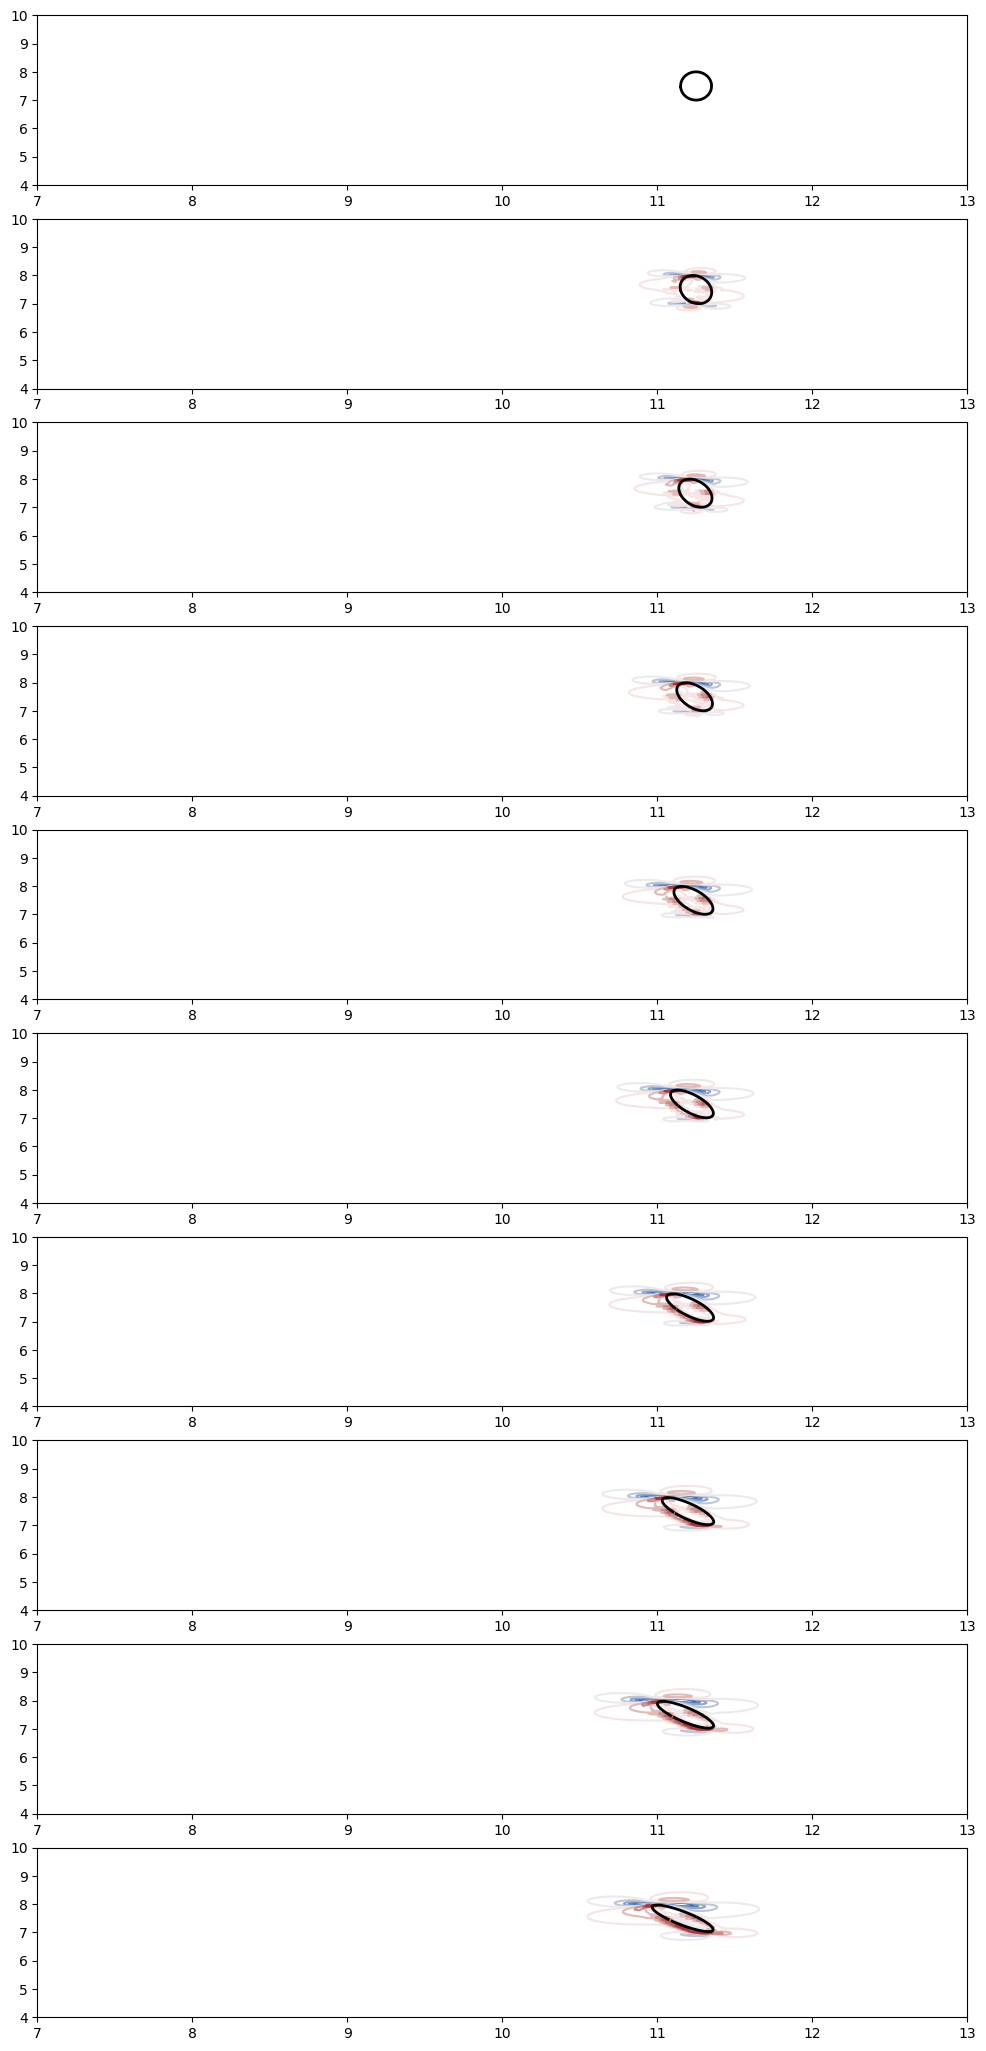

In [13]:
import matplotlib.pyplot as plt
import seaborn
import numpy as np

X,Y = grid.mesh(grid.cell_center)



def calc_vorticity(trajectory,idx):
    vel_bc = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0),
           boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0))


    velocity = (grids.GridVariable(grids.GridArray(trajectory.velocity[0].data[idx], trajectory.velocity[0].offset, trajectory.velocity[0].grid, 0), vel_bc[0]),
                     grids.GridVariable(grids.GridArray(trajectory.velocity[1].data[idx], trajectory.velocity[1].offset, trajectory.velocity[1].grid, 0), vel_bc[1]))

    return finite_differences.central_difference(velocity[1], axis=1).data- finite_differences.central_difference(velocity[0], axis=1).data



fig,ax = plt.subplots(figsize=(12,26),nrows=outer_steps)

idx = 2
counter=0
for idx in range(outer_steps):
    current_t = trajectory.time[idx]
    ax[counter].contour(X,Y,calc_vorticity(trajectory,idx),cmap=seaborn.color_palette("vlag", as_cmap=True),levels=np.linspace(-10, 10, 10))
    xp, yp = ellipse_position(current_t)
    ax[counter].set_xlim([7,13])
    ax[counter].set_ylim([4,10])
    ax[counter].plot(xp,yp,'k-',linewidth=2.0)
    counter+=1

In [83]:
_vy[6]

array([[-9.00796616e-05+3.15048109e-18j, -8.96803917e-05+2.78324685e-18j,
        -8.92697573e-05+2.40287669e-18j, ...,
        -9.12070637e-05+4.80035954e-18j, -9.08432203e-05+4.38485791e-18j,
        -9.04673453e-05+3.29622672e-18j],
       [-8.99331209e-05-1.99814709e-18j, -8.95342681e-05-1.67871961e-18j,
        -8.91240725e-05-8.10457485e-19j, ...,
        -9.10594045e-05-2.47806283e-18j, -9.06959116e-05-2.38898853e-18j,
        -9.03204095e-05-2.45174079e-18j],
       [-8.97981445e-05+2.08614457e-18j, -8.93994874e-05+1.94162386e-18j,
        -8.89895099e-05+1.40584751e-18j, ...,
        -9.09239780e-05+7.97544977e-19j, -9.05606122e-05+1.19187053e-18j,
        -9.01852602e-05+1.44805302e-18j],
       ...,
       [-9.05888846e-05+4.00469572e-18j, -9.01870320e-05+3.52141215e-18j,
        -8.97737550e-05+3.03933332e-18j, ...,
        -9.17236621e-05+4.56258805e-18j, -9.13574239e-05+4.19387135e-18j,
        -9.09790899e-05+3.83892236e-18j],
       [-9.04075226e-05+1.86368579e-18j, -9.

In [129]:
outer_steps


10

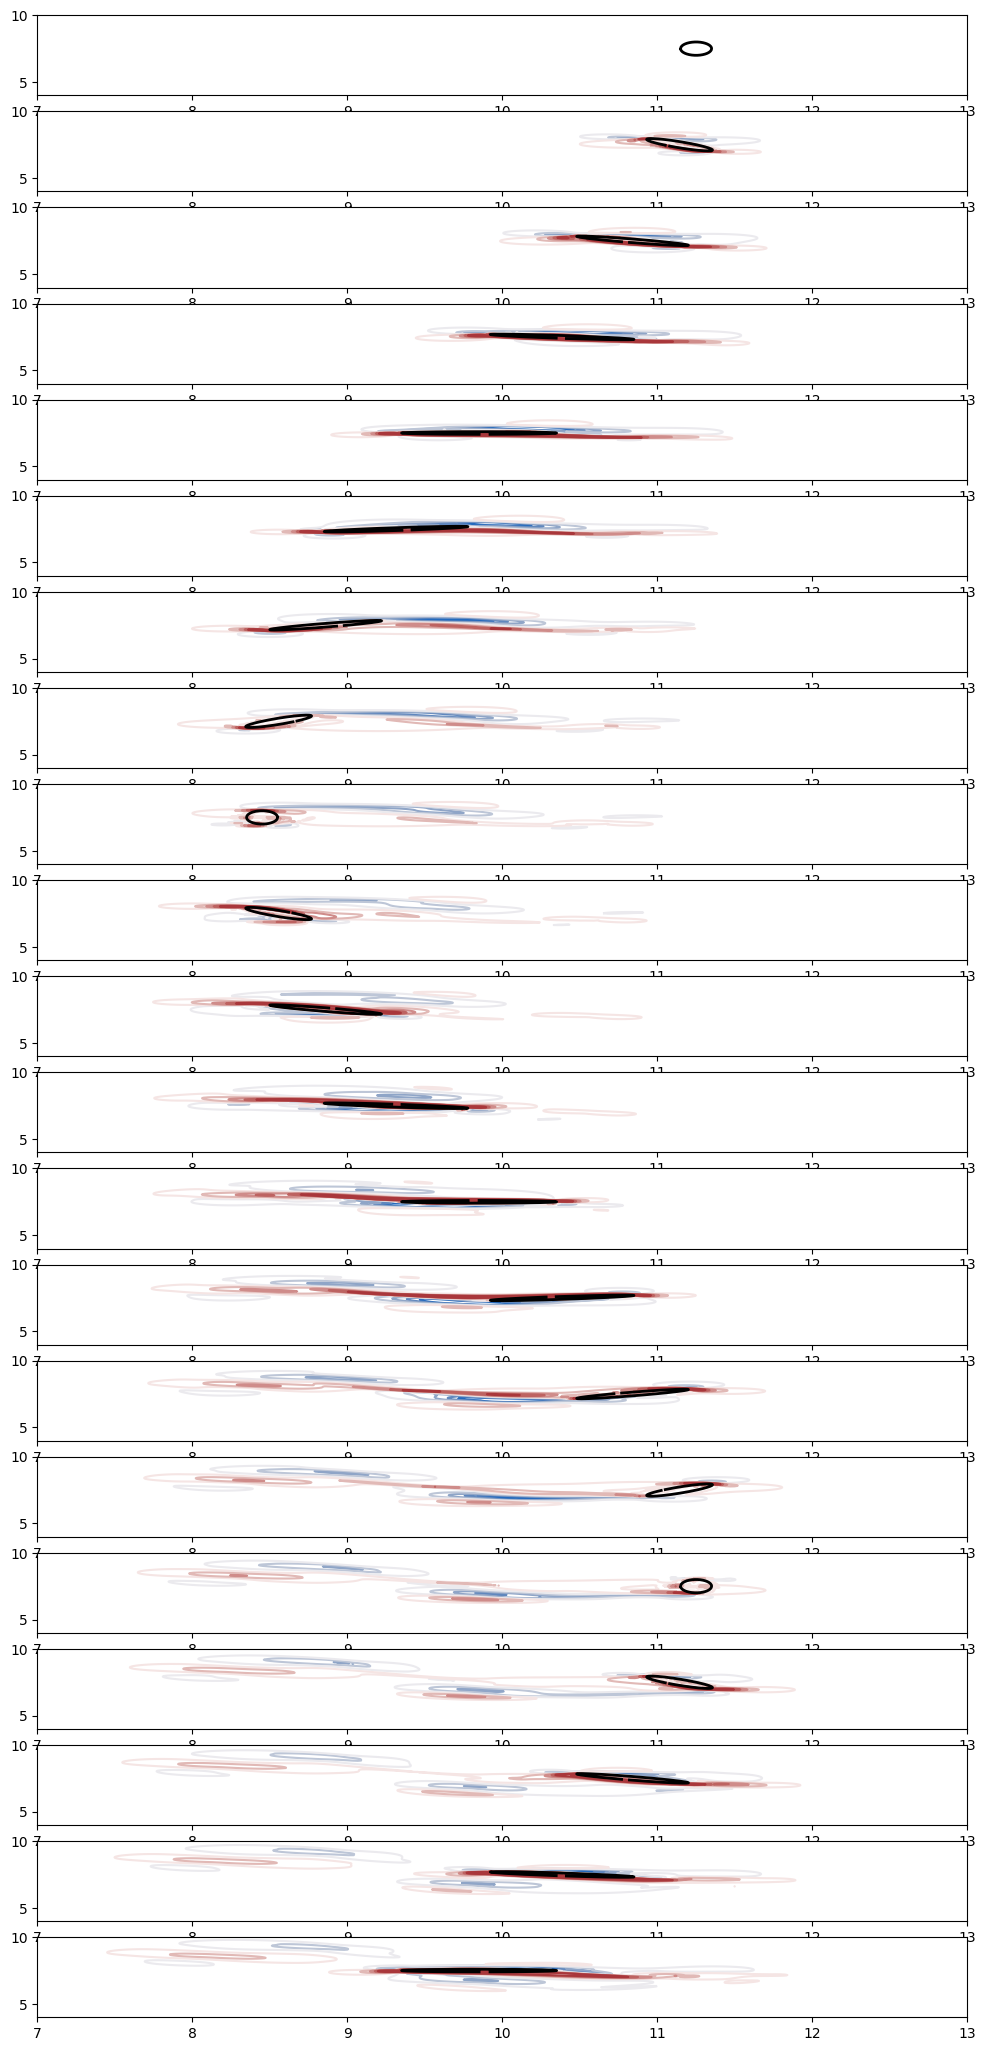

In [160]:
import matplotlib.pyplot as plt
import seaborn
import numpy as np

X,Y = grid.mesh(grid.cell_center)



def calc_vorticity_2(ux, offsetx, uy, offsety, grid, idx):
    vel_bc = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0),
           boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0))


    velocity = (grids.GridVariable(grids.GridArray(ux[idx], offsetx, grid, 0), vel_bc[0]),
                grids.GridVariable(grids.GridArray(uy[idx], offsety, grid, 0), vel_bc[1]))
    return finite_differences.central_difference(velocity[1], axis=1).data- finite_differences.central_difference(velocity[0], axis=1).data


osteps = len(uxs)
fig,ax = plt.subplots(figsize=(12,26),nrows=osteps//10+1)
counter=0
offsetx, offsety = global_velocities[0].offset, global_velocities[1].offset
for idx in range(0,osteps, 10):
    current_t = dt * idx*50
    ax[counter].contour(X,Y,calc_vorticity_2(uxs, offsetx, uys, offsety, grid, idx),cmap=seaborn.color_palette("vlag", as_cmap=True),levels=np.linspace(-10, 10, 10))
    xp, yp = ellipse_position(current_t)
    ax[counter].set_xlim([7,13])
    ax[counter].set_ylim([4,10])
    ax[counter].plot(xp,yp,'k-',linewidth=2.0)
    counter+=1